In [7]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
!pip install plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_excel('/content/drive/MyDrive/Solx/Market Pricing (Feb 2023 - Nov 2024).xlsx')

DEBUG:cmdstanpy:input tempfile: /tmp/tmpqye1h9s3/w6meow4e.json


Data Range:
Start Date: 2023-02-26 00:00:00
End Date: 2024-11-06 23:00:00
Total Hours: 14880


Training Data Range: 2023-02-26 00:00:00 to 2024-10-07 22:00:00
Test Data Range: 2024-10-07 23:00:00 to 2024-11-06 23:00:00




DEBUG:cmdstanpy:input tempfile: /tmp/tmpqye1h9s3/o58s829m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70229', 'data', 'file=/tmp/tmpqye1h9s3/w6meow4e.json', 'init=/tmp/tmpqye1h9s3/o58s829m.json', 'output', 'file=/tmp/tmpqye1h9s3/prophet_model6y3sbhmy/prophet_model-20241226155124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:51:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:51:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Model Evaluation Metrics on Test Set:
Mean Absolute Error (MAE): 2.4822
Root Mean Square Error (RMSE): 2.9060
R-squared Score: -2.4068
Mean Absolute Percentage Error (MAPE): nan%


Future Forecast Statistics:

Monthly Average Forecasted Prices:
              yhat  yhat_lower  yhat_upper
ds                                        
2024-11-30 -1.2119     -4.7018      2.2930
2024-12-31 -1.3349     -4.9384      2.3107
2025-01-31 -2.3510     -6.2693      1.6363
2025-02-28 -2.1062     -6.5014      2.3984
2025-03-31 -1.5142     -6.6197      3.7338
2025-04-30 -1.1324     -6.7206      4.6472


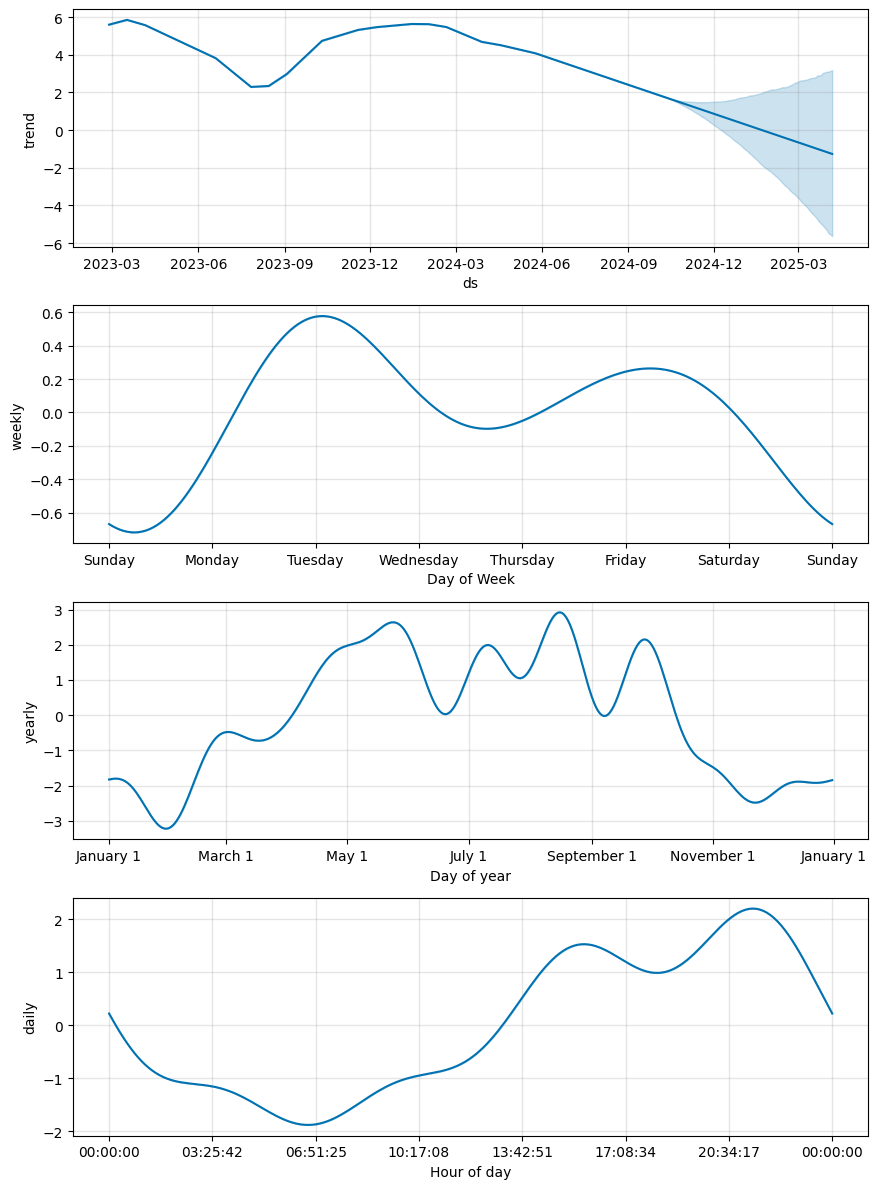

In [11]:
forecast_df = df.reset_index()[[df.index.name, 'Smoothed_Average']].rename(
    columns={df.index.name: 'ds', 'Smoothed_Average': 'y'})
print("Data Range:")
print(f"Start Date: {forecast_df['ds'].min()}")
print(f"End Date: {forecast_df['ds'].max()}")
print(f"Total Hours: {len(forecast_df)}")
print("\n")
test_start = forecast_df['ds'].max() - pd.Timedelta(days=30)
train = forecast_df[forecast_df['ds'] < test_start].copy()
test = forecast_df[forecast_df['ds'] >= test_start].copy()
print("Training Data Range:", train['ds'].min(), "to", train['ds'].max())
print("Test Data Range:", test['ds'].min(), "to", test['ds'].max())
print("\n")
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10,
    holidays_prior_scale=10
)
# model.add_country_holidays(country_name='PH') assumed that data i am using is from PH.
model.fit(train)
test_forecast = model.predict(test[['ds']])
mae = mean_absolute_error(test['y'], test_forecast['yhat'])
mse = mean_squared_error(test['y'], test_forecast['yhat'])
rmse = np.sqrt(mse)
r2 = r2_score(test['y'], test_forecast['yhat'])
mape = np.mean(np.abs((test['y'] - test_forecast['yhat']) / test['y'])) * 100
print("Model Evaluation Metrics on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
print("\n")
hours_in_6_months = 24 * 30 * 6
future_dates = model.make_future_dataframe(periods=hours_in_6_months, freq='H')
forecast = model.predict(future_dates)
print("Future Forecast Statistics:")
future_forecast = forecast[forecast['ds'] > forecast_df['ds'].max()]
print("\nMonthly Average Forecasted Prices:")
monthly_forecast = future_forecast.set_index('ds').resample('M')[['yhat', 'yhat_lower', 'yhat_upper']].mean()
print(monthly_forecast.round(4))
fig = go.Figure()
fig.add_trace(
    go.Scatter(x=forecast_df['ds'],
               y=forecast_df['y'],
               name='Historical Data',
               line=dict(color='blue'))
)
fig.add_trace(
    go.Scatter(x=test['ds'],
               y=test_forecast['yhat'],
               name='Test Predictions',
               line=dict(color='green', dash='dash'))
)
fig.add_trace(
    go.Scatter(x=future_forecast['ds'],
               y=future_forecast['yhat'],
               name='Future Forecast',
               line=dict(color='red', dash='dash'))
)
fig.add_trace(
    go.Scatter(x=future_forecast['ds'],
               y=future_forecast['yhat_upper'],
               name='Upper Bound',
               line=dict(width=0),
               showlegend=False)
)
fig.add_trace(
    go.Scatter(x=future_forecast['ds'],
               y=future_forecast['yhat_lower'],
               name='Lower Bound',
               line=dict(width=0),
               fill='tonexty',
               fillcolor='rgba(255, 0, 0, 0.1)',
               showlegend=False)
)
fig.update_layout(
    title='Market Price Forecast with Test Period and Future Predictions',
    xaxis_title='Date',
    yaxis_title='Price',
    showlegend=True,
    hovermode='x unified'
)
fig.show()
components_fig = model.plot_components(forecast)
plt.show()
